# DACON - 영화 관객수 예측 경진대회
[DACON - 영화 관객수 예측 경진대회](https://dacon.io/competitions/open/235536/data)
```
title : 영화의 제목
distributor : 배급사
genre : 장르
release_time : 개봉일
time : 상영시간(분)
screening_rat : 상영등급
director : 감독이름
dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
num_staff : 스텝수
num_actor : 주연배우수
box_off_num : 관객수

데이터 상세 설명
2010년대 한국에서 개봉한 한국영화 600개에 대한 감독, 이름, 상영등급, 관객수 등의 정보가 담긴 데이터
```


## EDA and Preprocessing

### 사용 라이브러리



In [594]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import re
import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgbm
from lightgbm import LGBMRegressor

xgboost와 lgbm을 사용했지만, 다른 모델을 사용해도 상관 없습니다

### Data Load

In [595]:
paths = glob.glob('*.csv')
paths

['movies_test.csv', 'movies_train.csv', 'submission.csv']

In [596]:
train, test = pd.read_csv(paths[1]), pd.read_csv(paths[0])

train.shape, test.shape

((600, 12), (243, 11))

In [597]:
# train과 test의 데이터를 출력해봅니다
display(train.head(3))
display(test.head(3))

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,300529.00,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,342700.25,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4206610.67,3,419,7


- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

### EDA and Preprocessing
#### 기본 정보

In [598]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [599]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (train)
pd.options.display.float_format = '{:.2f}'.format
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.00,270.00,600.00,600.00,600.00,600.00
mean,100.86,1050442.89,0.88,151.12,3.71,708181.75
std,18.10,1791408.30,1.18,165.65,2.45,1828005.85
min,45.00,1.00,0.00,0.00,0.00,1.00
25%,89.00,20380.00,0.00,17.00,2.00,1297.25
50%,100.00,478423.62,0.00,82.50,3.00,12591.00
75%,114.00,1286568.62,2.00,264.00,4.00,479886.75
max,180.00,17615314.00,5.00,869.00,25.00,14262766.00


In [600]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [601]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (test)
pd.options.display.float_format = '{:.2f}'.format
test.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.00,107.00,243.00,243.00,243.00
mean,109.80,891669.52,0.85,159.32,3.48
std,124.02,1217341.45,1.20,162.98,2.11
min,40.00,34.00,0.00,0.00,0.00
25%,91.00,62502.00,0.00,18.00,2.00
50%,104.00,493120.00,0.00,105.00,3.00
75%,114.50,1080849.58,1.00,282.00,4.00
max,2015.00,6173099.50,6.00,776.00,16.00


#### 결측치 확인

In [602]:
# train
train.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [603]:
# test
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

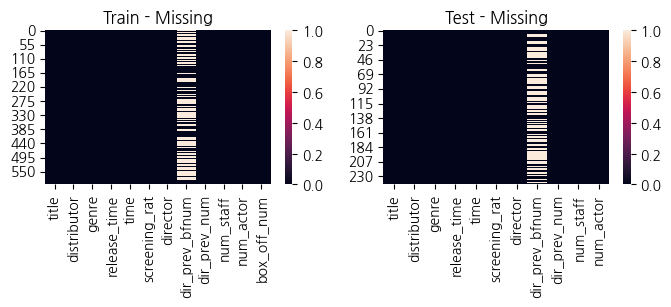

In [604]:
# 결측치를 시각화해봅니다
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,2));

sns.heatmap(data=train.isna(), ax=axes[0]);
axes[0].set(title='Train - Missing');
sns.heatmap(data=test.isna(), ax=axes[1]);
axes[1].set(title='Test - Missing');

`dir_prev_bfnum`은 해당 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수부분에 결측치가 존재함  
관객수가 알려지지 않은 부분이 결측치로 존재하는거라, 정보가 없다라는 정보 그 자체로 사용해도 괜찮을꺼 같음

#### distributor: 배급사

In [605]:
# \(|주|\) 는 데이터에서 제거해줍니다
train['distributor'] = [re.sub(r'[\(주\)]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[\(주\)]', '', x) for x in test.distributor]
train['distributor']

0       롯데엔터테인먼트
1            쇼박스
2            쇼박스
3            NEW
4      쇼박스미디어플렉스
         ...    
595          NEW
596          쇼박스
597       마운틴픽쳐스
598    CJ 엔터테인먼트
599    CJ 엔터테인먼트
Name: distributor, Length: 600, dtype: object

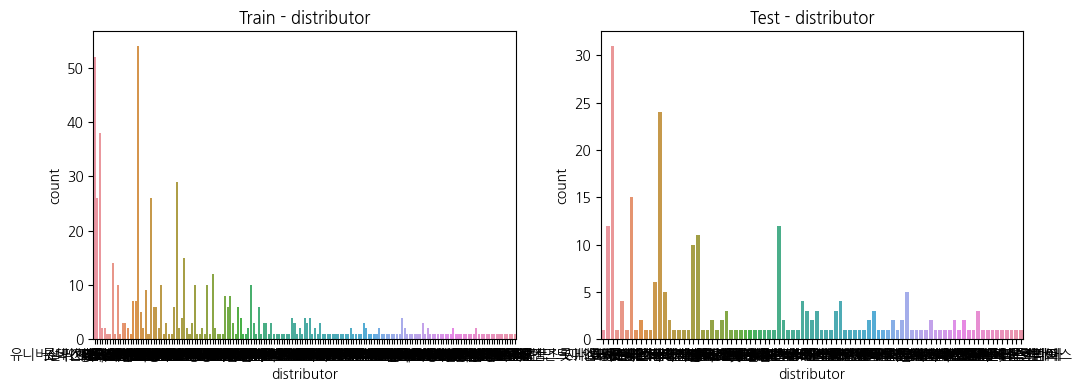

In [606]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4));

sns.countplot(data=train, x='distributor', ax=axes[0])
axes[0].set(title='Train - distributor');
sns.countplot(data=test, x='distributor', ax=axes[1])
axes[1].set(title='Test - distributor');

In [607]:
# 정규 표현식으로 문자와 숫자만 
train["distributor"] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [608]:
display([train['distributor']])
display([test['distributor']])

[0       롯데엔터테인먼트
 1            쇼박스
 2            쇼박스
 3            NEW
 4      쇼박스미디어플렉스
          ...    
 595          NEW
 596          쇼박스
 597       마운틴픽쳐스
 598     CJ엔터테인먼트
 599     CJ엔터테인먼트
 Name: distributor, Length: 600, dtype: object]

[0        시네마서비스
 1           쇼박스
 2      CJ엔터테인먼트
 3           쇼박스
 4      CJ엔터테인먼트
          ...   
 238         디씨드
 239       인디스토리
 240     컨텐츠온미디어
 241    씨타마운틴픽쳐스
 242       케이알씨지
 Name: distributor, Length: 243, dtype: object]

<AxesSubplot: >

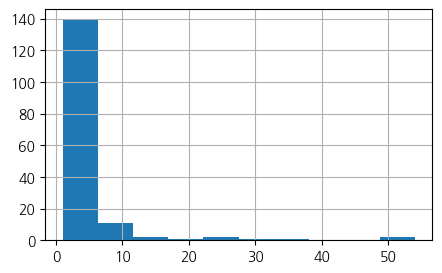

In [609]:
plt.figure(figsize=(5,3))
train["distributor"].value_counts().hist()

In [610]:
train["distributor"].value_counts().nlargest(10)

CJ엔터테인먼트    54
롯데엔터테인먼트    52
NEW         38
마운틴픽쳐스      29
인디스토리       26
쇼박스         26
시네마달        18
골든타이드픽처스    15
케이알씨지       14
영화사조제       10
Name: distributor, dtype: int64

In [611]:
# 배급사의 개수를 이용해 소형, 중대형으로 분리하기 위한 함수를 작성합니다
# 15개 이하면 소형, 이외면 중대형으로 분류 합니다
# large = ['CJ엔터테인먼트', '롯데엔터테인먼트', 'NEW', '마운틴픽쳐스', '인디스토리', '쇼박스', '시네마달']

# def distributor_band(x):
    
    # for x in range(len(train['distributor'])):
        # if train['distributor'][x] in large:
            # train.loc[x, 'distributor'] = '중대형'
        # else:
            # train.loc[x, 'distributor'] = '소형'


In [612]:
# train["distributor"].apply(distributor_band).value_counts()

In [613]:
# 위 함수를 train과 test에 모두 적용합니다

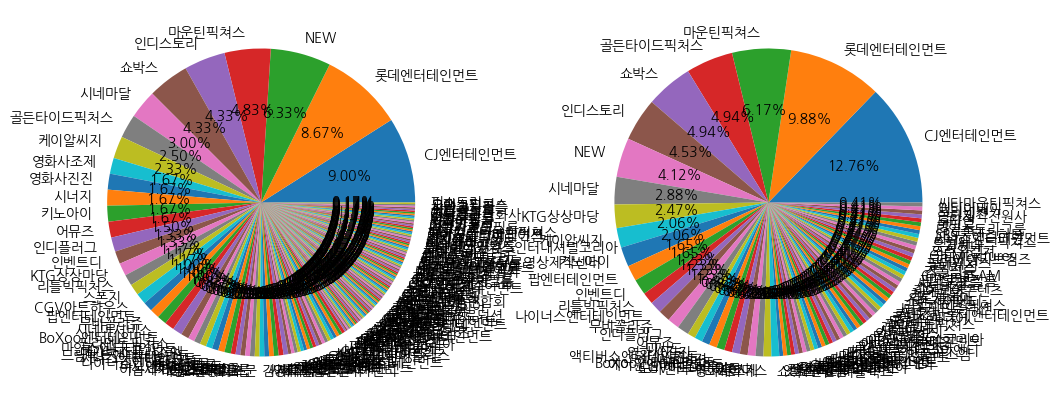

In [614]:
# pie 차트는 다음과 같이 그릴 수 있습니다
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pie(train["distributor"].value_counts().values, labels=train["distributor"].value_counts().index, autopct="%.2f%%")
ax[1].pie(test["distributor"].value_counts().values, labels=test["distributor"].value_counts().index, autopct="%.2f%%")
plt.show()

#### genre: 장르


In [615]:
train.groupby("genre")["box_off_num"].mean().sort_values()

genre
뮤지컬         6627.00
다큐멘터리      67172.26
서스펜스       82611.00
애니메이션     181926.67
멜로/로맨스    425968.04
미스터리      527548.18
공포        590832.52
드라마       625689.79
코미디      1193914.00
SF       1788345.69
액션       2203974.07
느와르      2263695.11
Name: box_off_num, dtype: float64

In [616]:
# 위에서 구한 장르로
# rank 딕셔너리를 하드코딩합니다
# 인코딩하는 과정입니다
rank = {'뮤지컬':1,
        '다큐멘터리':2,
        '서스펜스':3,
        '애니메이션':4,
        '멜로/로맨스':5,
        '미스터리':6,
        '공포':7,
        '드라마':8,
        '코미디':9,
        'SF':10,
        '액션':11,
        '느와르':12}

In [617]:
train["rank_genre"] = train["genre"].apply(lambda x: rank[x])
test["rank_genre"] = test["genre"].apply(lambda x: rank[x])

In [618]:
display(train.head(2))
display(test.head(2))

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,rank_genre
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,11
1,내부자들,쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,rank_genre
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,300529.00,2,304,3,12
1,아빠가 여자를 좋아해,쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,342700.25,4,275,3,5


In [619]:
# 인코딩 전의 장르 컬럼은 버려줍니다
train = train.drop(columns='genre', axis=1)
test = test.drop(columns='genre', axis=1)
train.columns, test.columns

(Index(['title', 'distributor', 'release_time', 'time', 'screening_rat',
        'director', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
        'box_off_num', 'rank_genre'],
       dtype='object'),
 Index(['title', 'distributor', 'release_time', 'time', 'screening_rat',
        'director', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
        'rank_genre'],
       dtype='object'))

### release_time: 개봉일

In [620]:
# 개봉일의 데이터타입은 datetime으로 변경합니다
train['release_time'] = pd.to_datetime(train['release_time'])
test['release_time'] = pd.to_datetime(test['release_time'])

In [621]:
# 연 월 일 요일 파생 변수를 train과 test에 생성합니다
train['year'] = train['release_time'].dt.year
train['month'] = train['release_time'].dt.month
train['day'] = train['release_time'].dt.day
train['dayofweek'] = train['release_time'].dt.dayofweek

test['year'] = test['release_time'].dt.year
test['month'] = test['release_time'].dt.month
test['day'] = test['release_time'].dt.day
test['dayofweek'] = test['release_time'].dt.dayofweek

In [622]:
# 기존 데이터는 삭제합니다
train = train.drop(columns='release_time', axis=1)
test = test.drop(columns='release_time', axis=1)
train.columns, test.columns

(Index(['title', 'distributor', 'time', 'screening_rat', 'director',
        'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
        'box_off_num', 'rank_genre', 'year', 'month', 'day', 'dayofweek'],
       dtype='object'),
 Index(['title', 'distributor', 'time', 'screening_rat', 'director',
        'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
        'rank_genre', 'year', 'month', 'day', 'dayofweek'],
       dtype='object'))

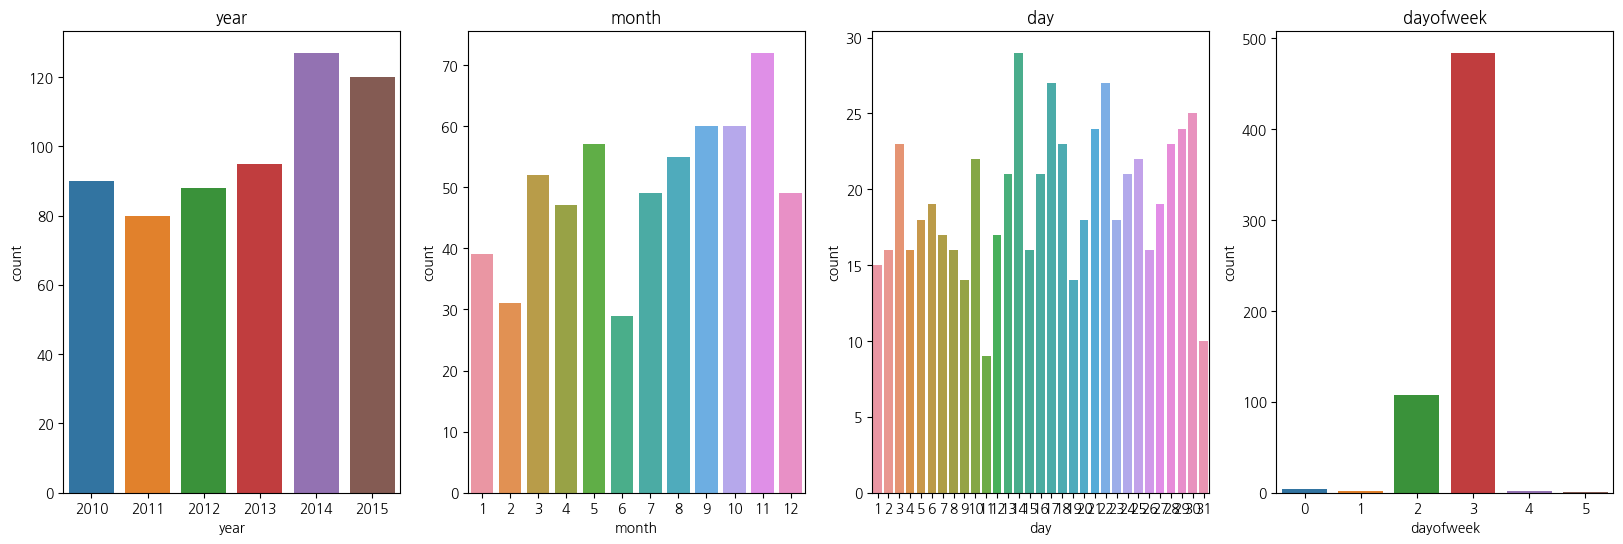

In [623]:
# 요일별로 시각화 해봅니다
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,6))

sns.countplot(data=train, x='year', ax=axes[0])
axes[0].set(title='year');
sns.countplot(data=train, x='month', ax=axes[1])
axes[1].set(title='month');
sns.countplot(data=train, x='day', ax=axes[2])
axes[2].set(title='day');
sns.countplot(data=train, x='dayofweek', ax=axes[3])
axes[3].set(title='dayofweek');

수요일, 목요일에 개봉한 영화들이 많고 목요일에 개봉한 영화가 유독 많음

## Train

In [624]:
label_name = 'box_off_num'
label_name

'box_off_num'

In [625]:
# 제목과 감독 데이터는 버려줍니다
feature_names = train.columns.tolist()
# feature_names.remove(label_name)
feature_names.remove('title')
feature_names.remove('director')
feature_names.remove('distributor')
feature_names

['time',
 'screening_rat',
 'dir_prev_bfnum',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'box_off_num',
 'rank_genre',
 'year',
 'month',
 'day',
 'dayofweek']

In [626]:
train["dir_prev_bfnum"].fillna(0, inplace=True)
test["dir_prev_bfnum"].fillna(0, inplace=True)

In [627]:
test.columns

Index(['title', 'distributor', 'time', 'screening_rat', 'director',
       'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
       'rank_genre', 'year', 'month', 'day', 'dayofweek'],
      dtype='object')

In [628]:
# 범주형 데이터들을 인코딩해줍니다
train = pd.get_dummies(data=train[feature_names])
test = pd.get_dummies(data=test[['time','dir_prev_bfnum','dir_prev_num','num_staff','num_actor','rank_genre','year','month',
                                 'day','dayofweek','screening_rat']])

In [630]:
train.shape, test.shape

((600, 15), (243, 14))

In [631]:
# 피처와 라벨을 구합니다
features = ['time',
 'dir_prev_bfnum',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'rank_genre',
 'year',
 'month',
 'day',
 'dayofweek',
 'screening_rat_12세 관람가',
 'screening_rat_15세 관람가',
 'screening_rat_전체 관람가',
 'screening_rat_청소년 관람불가']
features

['time',
 'dir_prev_bfnum',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'rank_genre',
 'year',
 'month',
 'day',
 'dayofweek',
 'screening_rat_12세 관람가',
 'screening_rat_15세 관람가',
 'screening_rat_전체 관람가',
 'screening_rat_청소년 관람불가']

In [632]:
label_name = 'box_off_num'
label_name

'box_off_num'

### Log Scale

In [633]:
train.columns

Index(['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
       'box_off_num', 'rank_genre', 'year', 'month', 'day', 'dayofweek',
       'screening_rat_12세 관람가', 'screening_rat_15세 관람가',
       'screening_rat_전체 관람가', 'screening_rat_청소년 관람불가'],
      dtype='object')

In [634]:
# 등장 배우의 수에 로그 스케일을 적용합니다
train["num_actor"] = np.log1p(train["num_actor"])

In [635]:
X_train, X_val, y_train, y_val = train_test_split(train[features], train[label_name], test_size=0.15)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (510, 14)
y_train: (510,)
X_val: (90, 14)
y_val: (90,)


In [636]:
test.shape

(243, 14)

### Random Forest

In [637]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42, n_jobs=-1)
model

RandomForestRegressor(n_jobs=-1, random_state=42)

In [661]:
y_predict = model.fit(X_train, y_train).predict(X_val)

In [655]:
from sklearn.model_selection import cross_val_predict
y_val_pred = cross_val_predict(model, X_train, y_train, cv=5, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


In [657]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_train, y_val_pred)
rmse = mse ** 1/2
rmse

1215406376395.675

<AxesSubplot: >

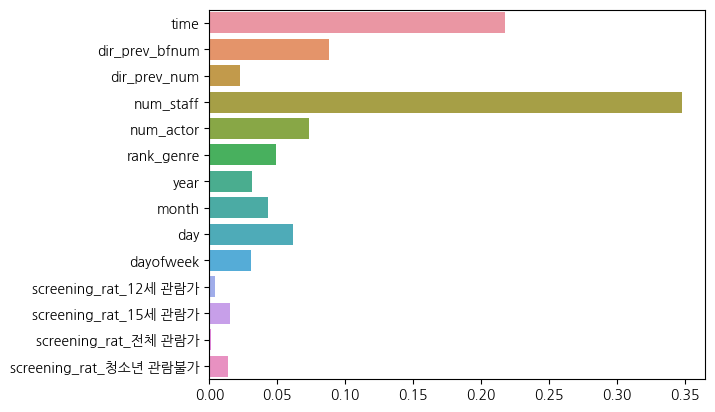

In [658]:
sns.barplot(x=model.feature_importances_, y=model.feature_names_in_)

### XGBoost

In [680]:
modelxgb = XGBRegressor(random_state=42, n_jobs=-1)


In [672]:
y_xgb_predict = model.fit(X_train, y_train).predict(X_val)

In [673]:
from sklearn.model_selection import cross_val_predict
y_val_pred_xgb = cross_val_predict(modelxgb, X_train, y_train, cv=5, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [674]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_train, y_val_pred_xgb)
rmse = mse ** 1/2
rmse

1601530879261.6428

In [677]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

plot_importance(modelxgb, ax=ax)

NotFittedError: need to call fit or load_model beforehand

### LightGBM

In [682]:
modellgbm = LGBMRegressor(randomstate=42, n_jobs=-1)

In [683]:
y_val_pred_lgbm = cross_val_predict(modellgbm, X_train, y_train, cv=5, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.3s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


In [684]:
mse = mean_squared_error(y_train, y_val_pred_lgbm)
rmse = mse ** 1/2
rmse

1203479320708.812

In [686]:
sns.barplot(x=modellgbm.feature_importances_, y=modellgbm.feature_name_)

NotFittedError: No feature_importances found. Need to call fit beforehand.

NotFittedError: No booster found. Need to call fit beforehand.

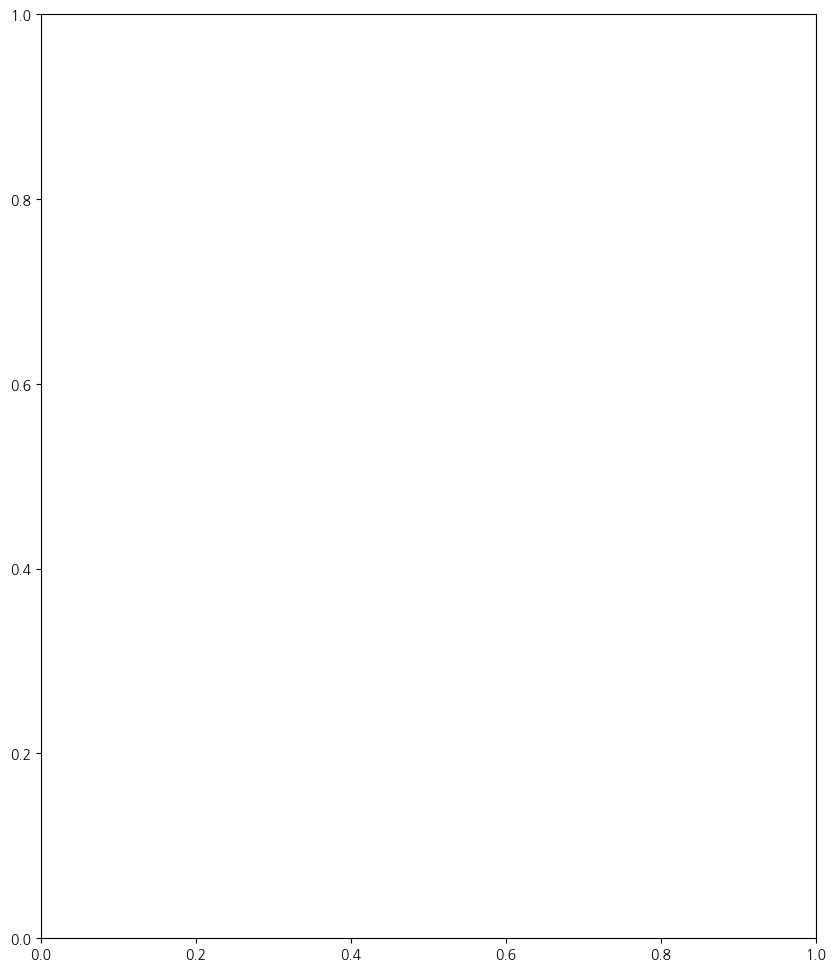

In [687]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(modellgbm, ax=ax)